__<h5>Safety inventory</h5>__
Safety inventory can help a supply chain improve product availability in the presence of supply and demand variability.

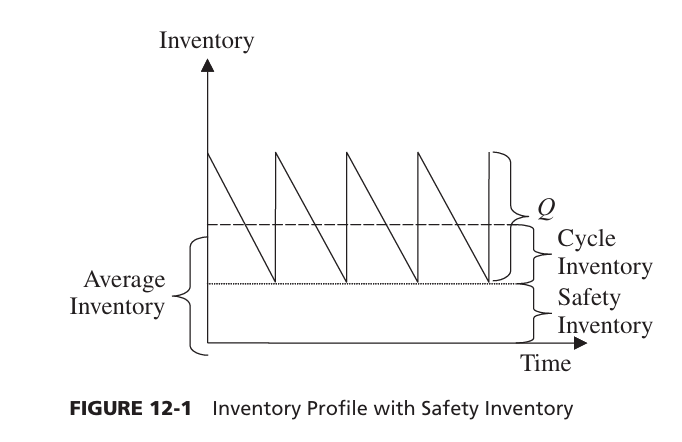

__Example:__ Bloomingdale sells Gucci purses. Demand is 100 per week. Gucci takes 3 weeks to deliver purses to Bloomingdale in response to an order. Therfore Bloomingdale can place an order when exactly 300 purses are remaining in the inventory.

Given deand fluctuations, demand over three weeks may be higher or lower than that of 300. If it is higher, Bloomingdale will lose sales. The store manager decides to put an order of 400 purses (therfore, safety level is 100).

__Goal:__ To determine the appropriate level of safety inventory.

__Replinishment policies:__
  1. __Continuous review:__ Inventory is continuously tracked, and an order for a lot size Q is placed when the inventory declines to the reorder point (ROP). As an example, consider the store manager at B&M who continuously tracks the inventory of phones. She orders 600 phones when the inventory drops below ROP 400. In this case, the size of the order does not change from one order to the next. The time between orders may fluctuate given variable demand.
  2. __Periodic review:__ Inventory status is checked at regular periodic intervals, and an order is placed to raise the inventory level to a specified threshold. As an example, consider the purchase of film at B&M. The store manager does not track film inventory continuously. Every Thursday, employees check film inventory, and the manager orders enough so that the total of the available inventory and the size of the order equals 1,000 films. In this case, the time between orders is fixed. The size of each order, however, can fluctuate given variable demand.

__<h5>Numerical Example 1: Evaluating Safety Inventory Given an Inventory Policy</h5>__

Assume that weekly demand for phones at B&M Office Supplies is normally distributed, with a mean of 2,500 and a standard deviation of 500. The manufacturer takes two weeks to fill an order placed by the B&M manager. The store manager currently orders 10,000 phones when the inventory on hand drops to 6,000. Evaluate the safety inventory and the average inventory carried by B&M. Also evaluate the average time a phone spends at B&M.

__Analytical Solution:__<br>
Under this replenishment policy, we have <br>
Average demand per week, $D = 2500$ <br>
Standard deviation of weekly demand, $\sigma_D = 500$ <br>
Average lead tme for replenishment, $L = 2$ Weeks <br>
Reorder point $ROP = 6000$ <br>
Average lot size $Q = 10000$ <br>

using eq 12.3 in the textbook,

safety inv, $ss = ROP - D^*L = 6000-5000 = 1000$ <br>
B&M thus carries a safety inventory of 1,000 phones.<br>

Cycle inventory = $\frac{Q}{3} = \frac{10000}{2} = 5000$

Average inventory = cycle inventory + safety inventory $= 5000 + 1000 = 6000$

Average flow time = average inventory/throughput $= \frac{6000}{2500} = 2.4$ weeks

__System:__

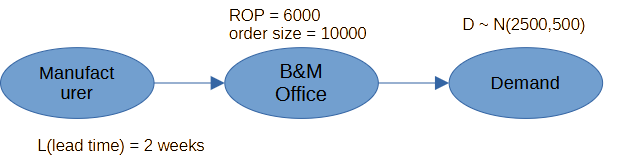

Cost per unit, transportation cost is not given. So we can assume anything. We want to find<br> 
- Safety inventory level (the average number of phones on hand when a replenishment order arrives).
- Cycle inventory (average inventory levels) 
- Average flowtime (average time spent by a product in the inventory)




__<h5>Numerical Example 2: Evaluating Cycle Service Level Given a Replenishment Policy</h5>__

Weekly demand for phones at B&M is normally distributed, with a mean of 2,500 and a standard deviation of 500. The replenishment lead time is two weeks. Assume that the demand is independent from one week to the next. Evaluate the CSL resulting from a policy of ordering 10,000 phones when there are 6,000 phones in inventory.

__Analysis:__ <br>
$Q = 10000$ <br>
$ROP = 6000$ <br>
$L = 2 $ weeks <br>
$D = 2500/$ week <br>
$\sigma_D = 500 $ <br>

Observe that B&M runs the risk of stocking out during the lead time of two weeks between when an order is placed and when the replenishment arrives. Thus, whether or not a stockout occurs depends on the demand during the lead time of two weeks.

Because demand across time is independent, we use Equation 12.2 to obtain demand during the lead time to be normally distributed with a mean of $D_L$ and a standard deviation of $\sigma_L$ where,

$D_L = D*L = 2 * 2500 = 5000$

$\sigma_L = \sqrt{L\sigma_D} = \sqrt{2 * 500 }= 707$

$CSL = NORMDIST(ROP,D_L,\sigma_L) = NORMDIST(6000,5000,707,1) = 0.92$

A CSL of 0.92 implies that in 92 percent of the replenishment cycles, B&M supplies all demand from available inventory. In the remaining 8 percent of the cycles, stockouts occur and some demand is not satisfied because of the lack of inventory.


	***
Safety Stock Level:  1393.5065689254689
Average Inventory Level: 6385.369028724683
Cycle Service Level:  100.0 %
Average Flow Time:  14.14453125 days 



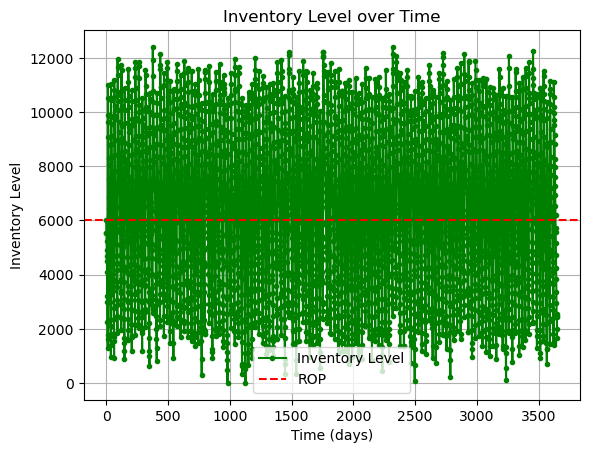

In [3]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
import SupplyNetPy.Components as scm

def normal_quantity():
    sample = np.random.normal(357, 188, 1)[0]
    if(sample<0):
        sample = 1
    return sample

simlen = 3650 # simulation length in days
env = simpy.Environment()

# create an infinite supplier
supplier1 = scm.Supplier(env=env, ID="S1", name="Supplier1", node_type="infinite_supplier")

#create the distributor
distributor1 = scm.InventoryNode(env=env, ID="D1", name="Distributor1", node_type="distributor",
                                capacity=16000, initial_level=6000, inventory_holding_cost=0.1, product_buy_price=0,
                                replenishment_policy=scm.SSReplenishment, policy_param={'s':6000,'S':16000}, product_sell_price=399)

link1 = scm.Link(env=env,ID="l1", source=supplier1, sink=distributor1, cost=100, lead_time=lambda: 14)

demand1 = scm.Demand(env=env,ID="d1", name="demand_d1", 
                    order_arrival_model=lambda: 1, 
                    order_quantity_model=normal_quantity, demand_node=distributor1)

scm.global_logger.disable_logging() # disable logging
env.run(until=simlen)

# calculate performance metrics
safety_stock = []
replenish_cycles = [0]

inv_levels = np.array(distributor1.inventory.instantaneous_levels) # instantaneous inventory levels
# lets calculate safety stock level
for i in range(len(inv_levels)-1):
    if(inv_levels[i,1]<inv_levels[i+1,1]): # inventory level is increasing that means a replenishment order is received
        safety_stock.append(inv_levels[i,1])
        replenish_cycles.append(inv_levels[i,0]) # time of replenishment order

unsat_demand = np.array(demand1.stats.demand_placed[1] - demand1.stats.orders_shortage[1]) # get record of unsatisfied demand, this is needed to calculate cycle service level
cycle_service_lvl = 0
prev_inx = -1
#for i in range(len(unsat_demand)):
#    inx = np.argmax(replenish_cycles > unsat_demand[i,0])
#    if(inx!=prev_inx):
#        cycle_service_lvl += 1
#    prev_inx = inx

# calculate average flow time (amount of time an item is stored in inventory)
flow_time = []
for i in range(len(replenish_cycles)-1):
    flow_time.append(replenish_cycles[i+1]-replenish_cycles[i])

print("\n\t***\nSafety Stock Level: ", np.mean(safety_stock))
print("Average Inventory Level:", np.mean(inv_levels[:,1]))
print("Cycle Service Level: ", (len(replenish_cycles)-cycle_service_lvl)*100/len(replenish_cycles),"%")
print("Average Flow Time: ", np.mean(flow_time)/2, "days","\n")

# plot the inventory level over time
plt.plot(inv_levels[:,0], inv_levels[:,1], marker='.', label="Inventory Level", color='green')
plt.axhline(y=6000, color='r', linestyle='--', label="ROP")
plt.xlabel("Time (days)")
plt.ylabel("Inventory Level")
plt.title("Inventory Level over Time")
plt.legend()
plt.grid()
plt.show()